# Libraries

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.autograph.set_verbosity(0)
from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import os

# Diagnosis & Parameters

In [2]:
diagnosis = 'death'

In [3]:
parameters = {
    'dx_offset' : 60,
    'pos_examples' : 10000,
    'neg_examples' : 10000,
    'ratio' : .5,           #pos/all
    'seq_length' : 100,
    'vocab_size' : 1000,
    'window' : [60*4, 60*0],
    'baseline' : [0, 360],
}

print(parameters['window'])

data_path = './'

[240, 0]


# Functions

In [4]:
def check_col_complete(dataframe):
    len_ = len(dataframe)

    incomplete = []
    for col in dataframe.columns:
        complete = dataframe[col].count() == len_
        if complete:
            print('{: >23}: COMPLETE'.format(col))
        else:
            missing = len_ - dataframe[col].count()
            incomplete.append(col)
            print('{: >23}: MISSING {} VALUES ({:.1f}%)'.format(col, missing, missing*100/len_))
    
    print('\nTotal number of items:', len_)

    return incomplete

In [5]:
def tokenize_text(x):
    tokenized = [word_to_ID[word] if word in word_to_ID else 
                                         word_to_ID['<unk>'] for word in x.split(';')]
    return tokenized
            

In [6]:
def pad_text(x):
    rem = parameters['seq_length'] - len(x)
    if rem > 0:
        pad = [word_to_ID['<unk>']]*abs(rem)
        x.extend(pad)
        return x
    else:
        return x[-parameters['seq_length']:]
    

# Diagnosis

In [7]:
dx = pd.read_csv('diagnosis.csv.gz')
dx.sample(5)

,diagnosisid,patientunitstayid,activeupondischarge,diagnosisoffset,diagnosisstring,icd9code,diagnosispriority
17244,12761844,970328,False,29,pulmonary|disorders of acid base|respiratory a...,"276.2, E87.2",Other
21666,9282762,524799,False,44,pulmonary|respiratory failure|acute respirator...,"518.81, J96.00",Major
16883,41156956,3115052,False,117,neurologic|altered mental status / pain|pain,NaN,Major
11778,31852198,2883334,False,389,pulmonary|respiratory failure|acute respirator...,"518.81, J96.00",Primary
5229,44009508,3145378,False,1794,cardiovascular|chest pain / ASHD|acute coronar...,"410.71, I21.4",Other


# Patient

In [8]:
d = pd.read_csv('patient.csv.gz')    
d = d[['patientunitstayid', 'unitdischargestatus', 'unitdischargeoffset', 'age']]
dx = d.merge(dx, on='patientunitstayid')
dx.head()

,patientunitstayid,unitdischargestatus,unitdischargeoffset,age,diagnosisid,activeupondischarge,diagnosisoffset,diagnosisstring,icd9code,diagnosispriority
0,143870,Alive,793,76,4035907,True,10,cardiovascular|chest pain / ASHD|coronary arte...,NaN,Other
1,143870,Alive,793,76,3843251,True,10,cardiovascular|post vascular surgery|s/p carto...,NaN,Primary
2,143870,Alive,793,76,3460672,True,10,cardiovascular|arrhythmias|bradycardia,NaN,Major
3,145427,Alive,1369,61,3516989,True,330,infectious diseases|systemic/other infections|...,"038.9, A41.9",Primary
4,145427,Alive,1369,61,3944483,False,167,gastrointestinal|post-GI surgery|s/p explorato...,NaN,Major


In [9]:
stay_min = parameters['window'][0] + parameters['baseline'][1]
dx = dx[dx.unitdischargeoffset>stay_min]
dx['age'] = dx.age.apply(lambda x: np.float(89) if x=='> 89' else np.float(x));
dx = dx[dx.age>15]

C:\Users\yagni\AppData\Local\Temp/ipykernel_32052/2914552510.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dx['age'] = dx.age.apply(lambda x: np.float(89) if x=='> 89' else np.float(x));


In [10]:
cols = ['patientunitstayid', 'diagnosisoffset']

if diagnosis=='death':
    dx_nonevents = dx[dx.unitdischargestatus=='Alive'].copy()[cols].sample(frac=1)
    dx_events = dx[dx.unitdischargestatus=='Expired'].copy()[cols]
    dx_events.sort_values(by='diagnosisoffset', inplace=True)
    dx_events.drop_duplicates('patientunitstayid', keep='last', inplace=True)
    dx_nonevents.drop_duplicates('patientunitstayid', keep='last', inplace=True)
else:
    dx_nonevents = dx[~dx.diagnosisstring.str.contains(diagnosis)].copy()[cols]
    dx_events = dx[dx.diagnosisstring.str.contains(diagnosis)].copy()[cols]
    dx_events.sort_values(by='diagnosisoffset', inplace=True)
    dx_events = dx_events[dx_events.diagnosisoffset>parameters['dx_offset']]
    dx_events.drop_duplicates('patientunitstayid', keep='first', inplace=True)
    dx_nonevents.drop_duplicates('patientunitstayid', keep='first', inplace=True)


In [11]:
print(f'Positive patients: {len(dx_events)}\nNegative patients: {len(dx_nonevents)}')

Positive patients: 94
Negative patients: 1931


In [12]:
pos_samples = len(dx_events)
neg_samples = len(dx_nonevents)
print(f"Positive examples: {len(dx_events)}")
print(f"Negative examples: {len(dx_nonevents)}")

Positive examples: 94
Negative examples: 1931


In [13]:
if pos_samples < parameters['pos_examples']:
    parameters['pos_examples'] = pos_samples
    
parameters['neg_examples'] = int((parameters['pos_examples'] - parameters['ratio'] * 
                                 parameters['pos_examples']) / parameters['ratio'])
if neg_samples < parameters['neg_examples']:
    parameters['neg_examples'] = neg_samples

In [14]:
dx_events = dx_events.sample(parameters['pos_examples'])
dx_nonevents = dx_nonevents.sample(parameters['neg_examples'])


print(f'Events: {len(dx_events)}\nNonevents: {len(dx_nonevents)}')

Events: 94
Nonevents: 94


In [15]:
dx_nonevents.drop_duplicates(inplace=True)

In [16]:
all_events = pd.concat([dx_events, dx_nonevents])

## PAST MEDICAL HISTORY

In [17]:
pmh = pd.read_csv('pastHistory.csv.gz')

In [18]:
pmh = pmh[['patientunitstayid', 'pasthistoryoffset', 'pasthistorypath', 'pasthistoryvalue', 'pasthistoryvaluetext']]
pmh = pmh[~(pmh['pasthistoryvalue'].isin(['Performed', 'No Health Problems', 'clinical diagnosis', '']))]
pmh['dx'] = pmh['pasthistoryvalue'].apply(lambda x: x.split('  -')[0].split(' -')[0]
                                          .split('-')[0].split(' requiring')[0])

In [19]:
print(f'Past medical diagnoses: {len(pmh)}\nUnique diagnoses: {len(pmh.dx.unique())}')

Past medical diagnoses: 8818
Unique diagnoses: 121


In [20]:
# TODO: Replace PMH diagnoses with ICD-9 Codes
pmh.dx.value_counts().nlargest(5)

hypertension                  1746
COPD                           627
CHF                            490
insulin dependent diabetes     457
medication dependent           397
Name: dx, dtype: int64

## Treatment

In [21]:
treatment = pd.read_csv('treatment.csv.gz')

In [22]:
treatment.drop(['treatmentid', 'activeupondischarge'], axis=1, inplace=True)

In [23]:
treatment['treatment'] = treatment['treatmentstring'].apply(lambda x: x.split('|')[-1])

In [24]:
most_common_tx = list(treatment.treatment.value_counts().nlargest(500).index)

In [25]:
treatment = treatment[treatment.treatment.isin(most_common_tx)]

In [26]:
treatment = treatment[treatment.patientunitstayid.isin(all_events.patientunitstayid)]

In [27]:
treatment.drop('treatmentstring', axis=1, inplace=True)

In [28]:
len(treatment.treatment.unique())

320

In [29]:
treatment.head()

,patientunitstayid,treatmentoffset,treatment
0,242895,838,enoxaparin
1,242895,512,Cardiology consultation
2,242895,838,external pacemaker
3,242895,70,enoxaparin
4,242895,70,Cardiology consultation


## ICU Diagnoses

In [30]:
dx.drop(['diagnosisid', 'activeupondischarge', 'diagnosispriority'], axis=1, inplace=True)
dx.drop_duplicates(inplace=True)

dx['icd9'] = dx['icd9code'].apply(lambda x: str(x).split(',')[0].split('.')[0])

dx.dropna(subset=['icd9code'], axis=0, inplace=True)

print(f'Total diagnoses: {len(dx)}')
print(f'Unique diagnoses: {len(dx.icd9.unique())}')

Total diagnoses: 20464
Unique diagnoses: 232


In [31]:
dx_to_icd = {
    'hypertension' : '401',
    'CHF' : '428', 
    'COPD' : '496',
    'insulin dependent diabetes' : '250',
    'renal insufficiency' : '585',
    'atrial fibrillation' : '427',
    'MI' : '410',
    'medication dependent' : '304', #questionable
    'renal failure' :'586',
    'hypothyroidism' : '244',
    'asthma' : '493', 
    'peripheral vascular disease' : '443',
    'stroke' : '434',
    'procedural coronary intervention' : '036', #questionable
    'home oxygen' : '093', #questionable
    'CABG' : '414',
    'peptic ulcer disease' : '533',
    'dementia' : '294',
    'DVT' : '453',
    'respiratory failure' : '518',
    'mechanical ventilation' : '096',
    'pneumonia' : '486',
    'pneumonitis' : '507',
    'hypotension' : '458',
    'cardiovascular symptoms' : '785',
    'unknown cause' : '799',
    'sepsis' : '038',
    'adverse effects' : '995',
    'pleurisy' : '511',
    'gi hemorrhage' : '578',
    'chronic bronchitis' : '491', 
    'malnutrition' : '263'
}

In [32]:
treatment.columns

Index(['patientunitstayid', 'treatmentoffset', 'treatment'], dtype='object')

In [33]:
dx.columns

Index(['patientunitstayid', 'unitdischargestatus', 'unitdischargeoffset',
       'age', 'diagnosisoffset', 'diagnosisstring', 'icd9code', 'icd9'],
      dtype='object')

In [34]:
tx_merge = treatment.copy()
tx_merge['id'] = tx_merge.pop('patientunitstayid')
tx_merge['offset'] = tx_merge.pop('treatmentoffset')
tx_merge['string'] = tx_merge.pop('treatment')

dx_merge = dx.copy()[['patientunitstayid', 'diagnosisoffset', 'icd9']]
dx_merge['id'] = dx_merge.pop('patientunitstayid')
dx_merge['offset'] = dx_merge.pop('diagnosisoffset')
dx_merge['string'] = dx_merge.pop('icd9')

merge = pd.concat([tx_merge, dx_merge])
merge = merge[merge.id.isin(all_events.patientunitstayid)]

In [35]:
len(merge)

6284

In [36]:
if diagnosis=='death':
    last_offset = merge.sort_values(by='offset')
    last_offset.drop_duplicates(subset=['id'], keep='last', inplace=True)
    last_offset.set_index('id', inplace=True)
    all_events_offset = pd.concat([dx_events, dx_nonevents])[['diagnosisoffset', 'patientunitstayid']]
    last_offset2 = pd.concat([all_events_offset.set_index('patientunitstayid'), last_offset], axis=1)
    last_offset2['last'] = last_offset2[['diagnosisoffset', 'offset']].max(axis=1)
    dx_offset_dict = pd.Series(last_offset2['last'].values,index=last_offset2.index).to_dict()

    dx_events['diagnosisoffset'] = dx_events.patientunitstayid.apply(lambda x: dx_offset_dict[x])
    dx_nonevents['diagnosisoffset'] = dx_nonevents.patientunitstayid.apply(lambda x: dx_offset_dict[x])
    
    print('offsets updated.')

offsets updated.


In [37]:
df = pd.DataFrame(columns=['patientunitstayid', 'dx_seq'])


for event_df in [dx_events, dx_nonevents]:
    for patientunitstayid in event_df.patientunitstayid:
            
        dx_offset = int(event_df[event_df['patientunitstayid']==patientunitstayid].diagnosisoffset - parameters['window'][1])
        
        pmh_seq = list(pmh[pmh['patientunitstayid'] == patientunitstayid].sort_values(by='pasthistoryoffset').dx)
        
        seq = list(merge[(merge['id'] == patientunitstayid) & (merge['offset'] <= dx_offset)]
                   .sort_values(by='offset').string)
                
        for i, d in enumerate(pmh_seq):
            try:
                pmh_seq[i] = dx_to_icd[d]
            except:
                continue
            
        df = df.append({'patientunitstayid' : patientunitstayid,
                        'dx_seq' : ';'.join(pmh_seq + seq)}, ignore_index=True)

In [38]:
tot_seq_len = []
for pt in df.dx_seq:
    tot_seq_len.append(len(pt.split(';')))

In [39]:
allcodes = ';'.join(df['dx_seq'].values).split(';')

In [40]:
counter = sorted(Counter(allcodes).items(), 
                 key=lambda x: -x[1])[:parameters['vocab_size']-1] # sort by frequency

min_word_ct = 20
counter2 = []
for word, count in counter:
    if count > min_word_ct:
        counter2.append((word, count))
    else:
        pass

counter2.append(('<unk>', 1))

words, _ = list(zip(*counter2))
word_to_ID = dict(zip(words, range(len(words))))

In [41]:
import pickle as pkl
pkl.dump(word_to_ID, open('./word_to_ID.pkl', 'wb'))

In [42]:
df['dx_seq_tok'] = df['dx_seq'].apply(tokenize_text).apply(pad_text)

In [43]:
np.array(list(df['dx_seq_tok']))

array([[ 4,  4,  4, ..., 96, 96, 96],
       [ 0, 96,  2, ..., 96, 96, 96],
       [ 4, 96,  0, ..., 96, 96, 96],
       ...,
       [28, 96, 96, ..., 96, 96, 96],
       [ 0, 96, 96, ..., 96, 96, 96],
       [15, 15, 55, ..., 96, 96, 96]])

## Periodic Vitals

In [44]:
vitals1 = pd.read_csv('vitalPeriodic.csv.gz')
vitals1.sample(5)

,vitalperiodicid,patientunitstayid,observationoffset,temperature,sao2,heartrate,respiration,cvp,etco2,systemicsystolic,systemicdiastolic,systemicmean,pasystolic,padiastolic,pamean,st1,st2,st3,icp
983589,1310730417,2216546,518,NaN,99.0,64.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.08,0.4,0.28,NaN
922201,1118428095,1856168,13586,NaN,98.0,82.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16128,1824053,167093,1088,NaN,96.0,74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,-0.1,-0.10,NaN
1252247,1636859326,2764138,10131,NaN,97.0,91.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42364,410437,205096,822,NaN,100.0,83.0,11.0,10.0,NaN,91.0,55.0,71.0,NaN,NaN,NaN,-0.10,-0.2,-0.10,NaN


In [45]:
# # Reduce the size of the dataframe.
vitals1 = vitals1[vitals1['patientunitstayid'].isin(all_events.patientunitstayid)]

In [46]:
check_col_complete(vitals1);

        vitalperiodicid: COMPLETE
      patientunitstayid: COMPLETE
      observationoffset: COMPLETE
            temperature: MISSING 160963 VALUES (93.0%)
                   sao2: MISSING 20269 VALUES (11.7%)
              heartrate: MISSING 546 VALUES (0.3%)
            respiration: MISSING 23784 VALUES (13.7%)
                    cvp: MISSING 132880 VALUES (76.8%)
                  etco2: MISSING 156051 VALUES (90.2%)
       systemicsystolic: MISSING 129811 VALUES (75.0%)
      systemicdiastolic: MISSING 129812 VALUES (75.0%)
           systemicmean: MISSING 129597 VALUES (74.9%)
             pasystolic: MISSING 170378 VALUES (98.4%)
            padiastolic: MISSING 170379 VALUES (98.4%)
                 pamean: MISSING 170370 VALUES (98.4%)
                    st1: MISSING 101230 VALUES (58.5%)
                    st2: MISSING 98236 VALUES (56.8%)
                    st3: MISSING 104560 VALUES (60.4%)
                    icp: MISSING 172252 VALUES (99.5%)

Total number of items: 1

In [47]:
vitals1.head()

,vitalperiodicid,patientunitstayid,observationoffset,temperature,sao2,heartrate,respiration,cvp,etco2,systemicsystolic,systemicdiastolic,systemicmean,pasystolic,padiastolic,pamean,st1,st2,st3,icp
21001,44155663,176050,1634,NaN,NaN,67.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21002,44175926,176050,884,NaN,98.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21003,44190574,176050,339,NaN,99.0,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21004,44133537,176050,2394,NaN,NaN,63.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21005,44153749,176050,1699,NaN,NaN,70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
vitals1['event_offset'] = vitals1['patientunitstayid'].apply(lambda x: dx_offset_dict[x])

In [49]:
vitals1['window'] = vitals1['observationoffset'].between(
    vitals1['event_offset'] - parameters['window'][0], vitals1['event_offset'] - parameters['window'][1])
vitals1['baseline'] = vitals1['observationoffset'].between(*parameters['baseline'])
vitals1['window2'] = vitals1['observationoffset']<(parameters['window'][1])

In [50]:
vitals1 = vitals1[vitals1.window | vitals1.baseline | vitals1.window2]

In [51]:
vitals1.columns

Index(['vitalperiodicid', 'patientunitstayid', 'observationoffset',
       'temperature', 'sao2', 'heartrate', 'respiration', 'cvp', 'etco2',
       'systemicsystolic', 'systemicdiastolic', 'systemicmean', 'pasystolic',
       'padiastolic', 'pamean', 'st1', 'st2', 'st3', 'icp', 'event_offset',
       'window', 'baseline', 'window2'],
      dtype='object')

In [52]:
vitals1.drop(['etco2', 'pasystolic', 'padiastolic', 'pamean', 'icp'], axis=1, inplace=True)

In [53]:
def create_feature(feature, period, operation, df):
    new_feat = df[df[period]==True][feature].groupby(df['patientunitstayid']).transform(operation)
    return new_feat

In [54]:
vitals1['hr_min_w1'] = create_feature('heartrate', "window", 'min', vitals1)
vitals1['hr_max_w1'] = create_feature('heartrate', "window", 'max', vitals1)
vitals1['hr_mean_bl'] = create_feature('heartrate', "baseline", 'mean', vitals1)

vitals1['resp_min_w1'] = create_feature('respiration', "window", 'min', vitals1)
vitals1['resp_max_w1'] = create_feature('respiration', "window", 'max', vitals1)
vitals1['resp_mean_bl'] = create_feature('respiration', "baseline", 'mean', vitals1)

vitals1['sao2_min_w1'] = create_feature('sao2', "window", 'min', vitals1)

In [55]:
vitals1 = vitals1.groupby(vitals1['patientunitstayid'].values).transform('max')

In [56]:
vitals1['hr_chg_bl'] = vitals1['hr_max_w1'] - vitals1['hr_mean_bl']
vitals1['resp_chg_bl'] = vitals1['resp_max_w1'] - vitals1['resp_mean_bl']

In [57]:
len(vitals1)

16800

In [58]:
vitals1.drop_duplicates(inplace=True)

In [59]:
vitals1[['patientunitstayid', 'hr_min_w1', 'hr_max_w1', ]].sample(5)

,patientunitstayid,hr_min_w1,hr_max_w1
1433016,3067309,0.0,111.0
558339,1115347,98.0,103.0
723520,1568200,67.0,87.0
816308,1733359,78.0,100.0
1317164,2831222,134.0,148.0


In [60]:
vitals1['label'] = vitals1['patientunitstayid'].isin(dx_events.patientunitstayid)

In [61]:
vitals1.groupby('label')['hr_max_w1'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
False,85.0,96.764706,20.459977,51.0,83.0,97.0,107.0,178.0
True,85.0,106.835294,25.184485,56.0,92.0,105.0,118.0,198.0


In [62]:
len(vitals1)

183

In [63]:
vitals1.columns

Index(['vitalperiodicid', 'patientunitstayid', 'observationoffset',
       'temperature', 'sao2', 'heartrate', 'respiration', 'cvp',
       'systemicsystolic', 'systemicdiastolic', 'systemicmean', 'st1', 'st2',
       'st3', 'event_offset', 'window', 'baseline', 'window2', 'hr_min_w1',
       'hr_max_w1', 'hr_mean_bl', 'resp_min_w1', 'resp_max_w1', 'resp_mean_bl',
       'sao2_min_w1', 'hr_chg_bl', 'resp_chg_bl', 'label'],
      dtype='object')

In [64]:
vitals_columns = ['patientunitstayid', 'hr_min_w1',
       'hr_max_w1', 'hr_mean_bl', 'resp_min_w1', 'resp_max_w1', 'resp_mean_bl',
       'sao2_min_w1', 'hr_chg_bl', 'resp_chg_bl', 'label']
vitals1 = vitals1[vitals_columns]
vitals1.columns

Index(['patientunitstayid', 'hr_min_w1', 'hr_max_w1', 'hr_mean_bl',
       'resp_min_w1', 'resp_max_w1', 'resp_mean_bl', 'sao2_min_w1',
       'hr_chg_bl', 'resp_chg_bl', 'label'],
      dtype='object')

In [65]:
check_col_complete(vitals1);

      patientunitstayid: COMPLETE
              hr_min_w1: MISSING 13 VALUES (7.1%)
              hr_max_w1: MISSING 13 VALUES (7.1%)
             hr_mean_bl: COMPLETE
            resp_min_w1: MISSING 29 VALUES (15.8%)
            resp_max_w1: MISSING 29 VALUES (15.8%)
           resp_mean_bl: MISSING 12 VALUES (6.6%)
            sao2_min_w1: MISSING 22 VALUES (12.0%)
              hr_chg_bl: MISSING 13 VALUES (7.1%)
            resp_chg_bl: MISSING 30 VALUES (16.4%)
                  label: COMPLETE

Total number of items: 183


## Labs

In [66]:
labs = pd.read_csv('lab.csv.gz')

In [67]:
len(labs)

434660

In [68]:
labs = labs[['patientunitstayid', 'labresultoffset', 'labtypeid', 'labname', 'labresult']]

In [69]:
labs = labs[labs['labtypeid']!=2]

In [70]:
labs_to_keep = ['bedside glucose',
 'potassium',
 'sodium',
 'glucose',
 'Hgb',
 'chloride',
 'Hct',
 'creatinine',
 'BUN',
 'calcium',
 'bicarbonate',
 'platelets x 1000',
 'WBC x 1000',
 'RBC',
 'MCV',
 'MCHC',
 'MCH',
 'RDW',
 'anion gap',
 'MPV',
 'magnesium',
 '-lymphs',
 '-monos',
 '-eos',
 '-polys',
 '-basos',
 'albumin',
 'AST (SGOT)',
 'ALT (SGPT)',
 'total protein',
 'alkaline phos.',
 'total bilirubin',
 'phosphate',
 'paO2',
 'paCO2',
 'pH',
 'PT - INR',
 'HCO3',
'lactate', 'albumin', 'total bilirubin', 'urinary specific gravity', 'FiO2'
]   ###Note platelets

In [71]:
labs = labs[labs.labname.isin(labs_to_keep)]

In [72]:
len(labs)

392581

In [73]:
labs = labs[labs.patientunitstayid.isin(dx_offset_dict)]

In [74]:
len(labs)

34406

In [75]:
labs['event_offset'] = labs['patientunitstayid'].apply(lambda x: dx_offset_dict[x])

In [76]:
labs["window"] = labs['labresultoffset'].between(
    labs['event_offset'] - parameters['window'][0], labs['event_offset'] - parameters['window'][1])
labs["baseline"] = labs['labresultoffset'].between(*parameters['baseline'])
labs['window2'] = labs['labresultoffset']<parameters['window'][1]

In [77]:
labs.sample(10)

,patientunitstayid,labresultoffset,labtypeid,labname,labresult,event_offset,window,baseline,window2
112510,2475260,4563,3,platelets x 1000,254.00,71.0,False,False,False
345320,1748443,9103,1,creatinine,0.40,4144.0,False,False,False
7088,1728137,1103,7,pH,7.12,7096.0,False,False,False
276812,3153171,659,3,-monos,6.00,6633.0,False,False,False
431799,1768103,2643,1,potassium,4.00,4451.0,False,False,False
130460,1694608,-4922,1,chloride,101.00,48.0,False,False,True
44378,1076172,394,7,HCO3,21.90,1140.0,False,False,False
342277,2566203,750,1,creatinine,3.03,376.0,False,False,False
252404,1824650,-1575,3,MPV,8.50,661.0,False,False,True
7224,1728137,428,3,MCH,39.40,7096.0,False,False,False


In [78]:
labs = labs[labs.window|labs.baseline|labs.window2]

In [79]:
len(labs)

11591

In [80]:
labs.sample(10)

,patientunitstayid,labresultoffset,labtypeid,labname,labresult,event_offset,window,baseline,window2
222962,2607275,-287,3,MCH,27.0,1184.0,False,False,True
274094,2607173,-2015,1,total protein,6.6,370.0,False,False,True
404843,2704188,-457,7,HCO3,12.4,47.0,False,False,True
345209,1748443,-19697,3,MCV,87.7,4144.0,False,False,True
134482,1433842,-71,7,paO2,136.0,89.0,True,False,True
288845,1090039,-3,3,MCH,28.1,27877.0,False,False,True
136383,3130903,129,3,-polys,74.0,2217.0,False,True,False
89278,1578108,323,1,lactate,2.0,6201.0,False,True,False
389412,3144615,-289,1,alkaline phos.,87.0,508.0,False,False,True
377235,3204052,-291,3,MCH,32.2,1736.0,False,False,True


In [81]:
def create_lab(lab, period, operation, df):
    new_feat = df[(df[period]==True) & (df['labname'].str.contains(lab))]['labresult'].groupby(df['patientunitstayid']).transform(operation)
    return new_feat

In [82]:
labs['gluc_mean_bl'] = create_lab('glucose', "baseline", 'mean', labs)
labs['gluc_max_w1'] = create_lab('glucose', "window", 'max', labs)
labs['gluc_min_w1'] = create_lab('glucose', "window", 'min', labs)

labs['k_mean_bl'] = create_lab('potassium', "baseline", 'mean', labs)
labs['k_min_w2'] = create_lab('potassium', "window2", 'min', labs)
labs['k_max_w2'] = create_lab('potassium', "window2", 'max', labs)

labs['na_mean_bl'] = create_lab('sodium', "baseline", 'mean', labs)
labs['na_min_w2'] = create_lab('sodium', "window2", 'min', labs)
labs['na_max_w2'] = create_lab('sodium', "window2", 'max', labs)

labs['hgb_mean_bl'] = create_lab('Hgb', "baseline", 'mean', labs)
labs['hgb_min_w2'] = create_lab('Hgb', "window2", 'min', labs)

labs['cl_mean_bl'] = create_lab('chloride', "baseline", 'mean', labs)
labs['cl_min_w2'] = create_lab('chloride', "window2", 'min', labs)
labs['cl_max_w2'] = create_lab('chloride', "window2", 'max', labs)

labs['hct_min_w2'] = create_lab('Hct', "window2", 'min', labs)

labs['crt_min_w2'] = create_lab('creatinine', "window2", 'min', labs)
labs['crt_mean_w2'] = create_lab('creatinine', "window2", 'mean', labs)
labs['crt_max_w1'] = create_lab('creatinine', "window", 'max', labs)

labs['bun_mean_w1'] = create_lab('BUN', "window", 'mean', labs)

labs['ca_min_w2'] = create_lab('calcium', "window2", 'min', labs)
labs['ca_max_w2'] = create_lab('calcium', "window2", 'max', labs)

labs['bicarb_mean_w1'] = create_lab('bicarbonate', "window", 'mean', labs)
labs['wbc_max_w2'] = create_lab('WBC x 1000', "window", 'max', labs)
labs['angap_max_w1'] = create_lab('anion gap', "window", 'max', labs)
labs['angap_max_w2'] = create_lab('anion gap', "window2", 'max', labs)


labs['hco3_min_w2'] = create_lab('HCO3', "window2", 'min', labs)
labs['hco3_max_w2'] = create_lab('HCO3', "window2", 'max', labs)
labs['pao2_min_w2'] = create_lab('paO2', "window2", 'min', labs)
labs['paco2_max_w2'] = create_lab('paCO2', "window2", 'mean', labs)

labs['ph_min_w2'] = create_lab('pH', "window2", 'min', labs)
labs['ph_max_w2'] = create_lab('pH', "window2", 'max', labs)
labs['inr_max_w2'] = create_lab('PT - INR', "window2", 'max', labs)
labs['lymphs_max_w2'] = create_lab('-lymphs', "window2", 'max', labs)
labs['lact_max_w2'] = create_lab('lactate', "window2", 'max', labs)
labs['alb_min_w2'] = create_lab('albumin', "window2", 'min', labs)
labs['tbili_max_w2'] = create_lab('total bilirubin', "window2", 'max', labs)
labs['usg_max_w2'] = create_lab('urinary specific gravity', "window2", 'max', labs)
labs['fio2_mean_w2'] = create_lab('FiO2', "window2", 'mean', labs)
labs['plt_min_w2'] = create_lab('platelets x 1000', 'window2', 'min', labs)
labs['rbc_max_w2'] = create_lab('RBC', "window2", 'max', labs)

In [83]:
labs = labs.groupby(labs['patientunitstayid'].values).transform('max')

In [84]:
labs['bun_crt_rat'] = labs['bun_mean_w1'] / labs['crt_mean_w2']
labs['crt_chg'] = labs['crt_max_w1'] / labs['crt_min_w2']
labs['hgb_chg'] = labs['hgb_mean_bl'] - labs['hgb_min_w2']
labs['k_chg'] = labs['k_max_w2'] - labs['k_mean_bl']
labs['pao2_fio2_rat'] = labs['pao2_min_w2'] / labs['fio2_mean_w2']

In [85]:
labs_cols_to_keep = ['patientunitstayid', 
       'gluc_mean_bl', 'gluc_max_w1', 'gluc_min_w1', 'k_mean_bl', 'k_min_w2',
       'k_max_w2', 'na_mean_bl', 'na_min_w2', 'na_max_w2', 'hgb_mean_bl',
       'hgb_min_w2', 'cl_mean_bl', 'cl_min_w2', 'cl_max_w2', 'hct_min_w2',
       'crt_min_w2', 'crt_mean_w2', 'crt_max_w1', 'bun_mean_w1', 'ca_min_w2',
       'ca_max_w2', 'bicarb_mean_w1', 'wbc_max_w2', 'angap_max_w1',
       'angap_max_w2', 'hco3_min_w2', 'hco3_max_w2', 'pao2_min_w2',
       'paco2_max_w2', 'ph_min_w2', 'ph_max_w2', 'inr_max_w2', 'lymphs_max_w2',
       'lact_max_w2', 'alb_min_w2', 'tbili_max_w2', 'usg_max_w2',
       'fio2_mean_w2', 'plt_min_w2', 'rbc_max_w2',
       'bun_crt_rat', 'crt_chg', 'hgb_chg', 'k_chg', 'pao2_fio2_rat',
       ]
labs = labs[labs_cols_to_keep]

In [86]:
labs.drop_duplicates(inplace=True)

## Aperiodic Vitals

In [87]:
vitals2 = pd.read_csv('vitalAperiodic.csv.gz')
vitals2.sample(5)

,vitalaperiodicid,patientunitstayid,observationoffset,noninvasivesystolic,noninvasivediastolic,noninvasivemean,paop,cardiacoutput,cardiacinput,svr,svri,pvr,pvri
21714,26337245,341780,4572,NaN,NaN,NaN,NaN,NaN,NaN,507.0,NaN,NaN,NaN
50223,125248298,521456,52263,153.0,55.0,77.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
255928,415701620,3140490,12755,125.0,83.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
248728,402583702,3107149,274,77.0,63.0,67.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
158678,298341768,2095984,3661,115.0,44.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
vitals2 = vitals2[vitals2['patientunitstayid'].isin(dx_offset_dict)]

In [89]:
vitals2['event_offset'] = vitals2['patientunitstayid'].apply(lambda x: dx_offset_dict[x] if x in dx_offset_dict else 0)

In [90]:
vitals2["window"] = vitals2['observationoffset'].between(
    vitals2['event_offset'] - parameters['window'][0], vitals2['event_offset'] - parameters['window'][1])
vitals2["baseline"] = vitals2['observationoffset'].between(*parameters['baseline'])

In [91]:
vitals2 = vitals2[vitals2.window | vitals2.baseline]

In [92]:
vitals2.drop(['vitalaperiodicid', 'paop', 'cardiacoutput', 'cardiacinput', 'svr', 'svri', 'pvr', 'pvri'], axis=1, inplace=True)

In [93]:
vitals2['noninv_mean_w1'] = create_feature('noninvasivemean', "window", 'mean', vitals2)
vitals2['noninv_mean_bl'] = create_feature('noninvasivemean', "baseline", 'mean', vitals2)

vitals2['noninv_syst_max_wl'] = create_feature('noninvasivesystolic', "window", 'max', vitals2)
vitals2['noninv_syst_min_wl'] = create_feature('noninvasivesystolic', "window", 'min', vitals2)

vitals2['noninv_dias_max_wl'] = create_feature('noninvasivediastolic', "window", 'max', vitals2)
vitals2['noninv_dias_min_wl'] = create_feature('noninvasivediastolic', "window", 'min', vitals2)

In [94]:
vitals2 = vitals2.groupby(vitals2['patientunitstayid'].values).transform('max')

In [95]:
vitals2['noninv_chg'] = vitals2['noninv_mean_w1'] - vitals2['noninv_mean_bl']

In [96]:
vitals2.drop_duplicates(inplace=True)

In [97]:
vitals2_columns = ['patientunitstayid', 'noninv_mean_w1', 'noninv_mean_bl', 'noninv_chg',
       'noninv_syst_max_wl', 'noninv_syst_min_wl', 'noninv_dias_max_wl',
       'noninv_dias_min_wl']
vitals2 = vitals2[vitals2_columns]
vitals2.columns

Index(['patientunitstayid', 'noninv_mean_w1', 'noninv_mean_bl', 'noninv_chg',
       'noninv_syst_max_wl', 'noninv_syst_min_wl', 'noninv_dias_max_wl',
       'noninv_dias_min_wl'],
      dtype='object')

## Patient Data

In [98]:
features3 = pd.read_csv('patient.csv.gz')

In [99]:
# # Reduce the size of the dataframe.
features3 = features3[(features3['patientunitstayid'].isin(dx_events.patientunitstayid)) |
                                       (features3['patientunitstayid'].isin(dx_nonevents.patientunitstayid))]

features3 = features3[['patientunitstayid', 'gender', 'age', 'admissionweight', 'unittype', 'unitadmitsource', 'ethnicity']]

In [100]:
features3['age'] = features3.age.apply(lambda x: np.float(89) if x=='> 89' else np.float(x));

C:\Users\yagni\AppData\Local\Temp/ipykernel_32052/1911930956.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  features3['age'] = features3.age.apply(lambda x: np.float(89) if x=='> 89' else np.float(x));


# Merge All Features

In [101]:
vitals1 = vitals1.set_index('patientunitstayid')
vitals2 = vitals2.set_index('patientunitstayid')
features3 = features3.set_index('patientunitstayid')
labs = labs.set_index('patientunitstayid')

In [102]:
vitals1 = vitals1.loc[~vitals1.index.duplicated(keep='first')]
vitals2 = vitals2.loc[~vitals2.index.duplicated(keep='first')]
features3 = features3.loc[~features3.index.duplicated(keep='first')]
labs = labs.loc[~labs.index.duplicated(keep='first')]

features = pd.concat([vitals1, vitals2], axis=1)
features = pd.concat([features, features3], axis=1)
features = pd.concat([features, labs], axis=1)

In [103]:
df = df.set_index('patientunitstayid')
df = df.loc[~df.index.duplicated(keep='first')]

In [104]:
df_merged = pd.concat([df, features], axis=1)

In [105]:
df_merged['label'] = df_merged.index.isin(dx_events.patientunitstayid)

# EDA

## CorrPlot

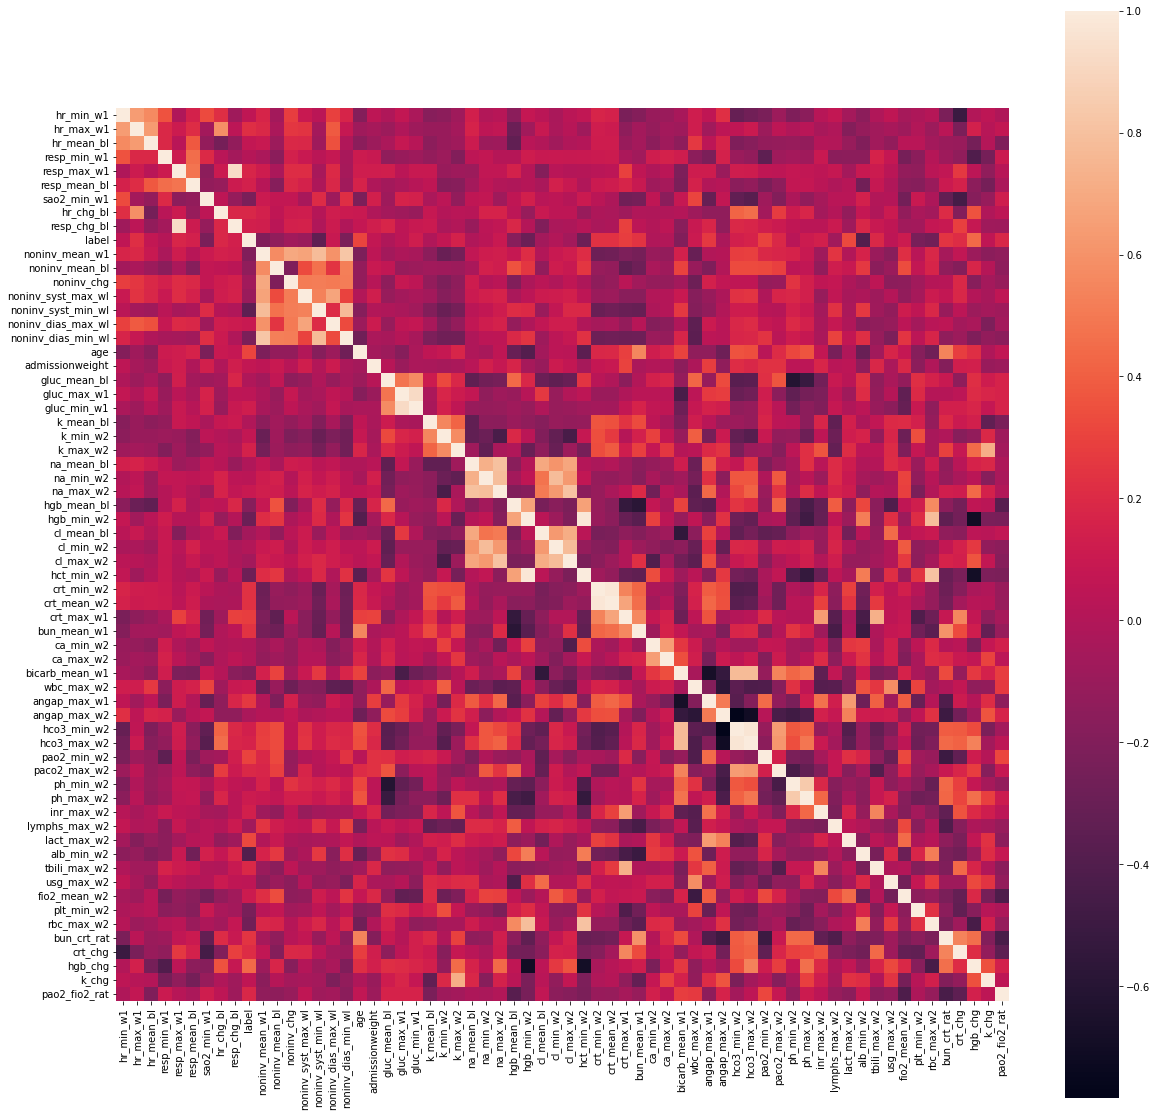

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns
corrmat = df_merged.corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, square=True);

In [126]:
df_merged.corr()['label'].sort_values()

alb_min_w2           -0.399453
noninv_syst_min_wl   -0.346100
hgb_min_w2           -0.292589
hct_min_w2           -0.283555
rbc_max_w2           -0.263752
                        ...   
pao2_min_w2           0.300313
age                   0.306246
lact_max_w2           0.319553
hgb_chg               0.440043
label                 1.000000
Name: label, Length: 64, dtype: float64

## Gender Plot

<Axes: xlabel='gender', ylabel='count'>

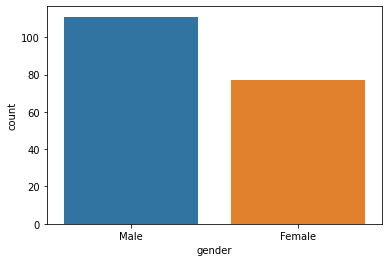

In [112]:
sns.countplot(df_merged.gender)

In [115]:
df_merged.columns.tolist()

['dx_seq',
 'dx_seq_tok',
 'hr_min_w1',
 'hr_max_w1',
 'hr_mean_bl',
 'resp_min_w1',
 'resp_max_w1',
 'resp_mean_bl',
 'sao2_min_w1',
 'hr_chg_bl',
 'resp_chg_bl',
 'label',
 'noninv_mean_w1',
 'noninv_mean_bl',
 'noninv_chg',
 'noninv_syst_max_wl',
 'noninv_syst_min_wl',
 'noninv_dias_max_wl',
 'noninv_dias_min_wl',
 'gender',
 'age',
 'admissionweight',
 'unittype',
 'unitadmitsource',
 'ethnicity',
 'gluc_mean_bl',
 'gluc_max_w1',
 'gluc_min_w1',
 'k_mean_bl',
 'k_min_w2',
 'k_max_w2',
 'na_mean_bl',
 'na_min_w2',
 'na_max_w2',
 'hgb_mean_bl',
 'hgb_min_w2',
 'cl_mean_bl',
 'cl_min_w2',
 'cl_max_w2',
 'hct_min_w2',
 'crt_min_w2',
 'crt_mean_w2',
 'crt_max_w1',
 'bun_mean_w1',
 'ca_min_w2',
 'ca_max_w2',
 'bicarb_mean_w1',
 'wbc_max_w2',
 'angap_max_w1',
 'angap_max_w2',
 'hco3_min_w2',
 'hco3_max_w2',
 'pao2_min_w2',
 'paco2_max_w2',
 'ph_min_w2',
 'ph_max_w2',
 'inr_max_w2',
 'lymphs_max_w2',
 'lact_max_w2',
 'alb_min_w2',
 'tbili_max_w2',
 'usg_max_w2',
 'fio2_mean_w2',
 'plt_min_

## Age

<Axes: xlabel='age', ylabel='Count'>

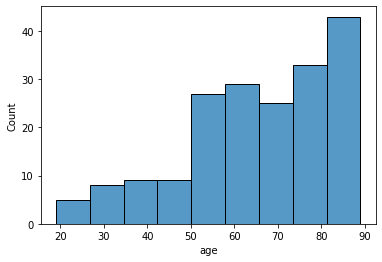

In [116]:
sns.histplot(df_merged.age)

# Label

<Axes: xlabel='label', ylabel='count'>

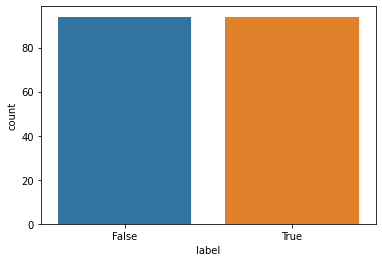

In [118]:
sns.countplot(df_merged.label)

## Ethinicity

<Axes: xlabel='ethnicity', ylabel='count'>

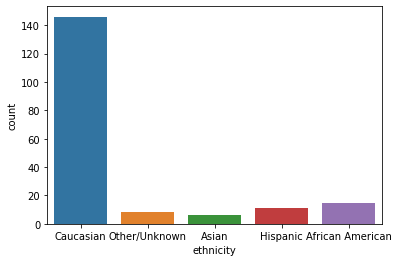

In [119]:
sns.countplot(df_merged.ethnicity)

# Clean and Preprocess Features

In [492]:
df_merged = df_merged.dropna(thresh=37)

In [494]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()

cat_attribs = ['gender', 'unittype', 'unitadmitsource', 'ethnicity']
num_attribs = ['hr_min_w1', 'hr_max_w1', 'hr_mean_bl',
       'resp_min_w1', 'resp_max_w1', 'resp_mean_bl', 'sao2_min_w1',
       'hr_chg_bl', 'resp_chg_bl', 'noninv_mean_w1', 'noninv_mean_bl',
       'noninv_chg', 'noninv_syst_max_wl', 'noninv_syst_min_wl',
       'noninv_dias_max_wl', 'noninv_dias_min_wl', 'age', 'admissionweight', 
       'gluc_mean_bl', 'gluc_max_w1', 'gluc_min_w1', 'k_mean_bl', 'k_min_w2',
       'k_max_w2', 'na_mean_bl', 'na_min_w2', 'na_max_w2', 'hgb_mean_bl',
       'hgb_min_w2', 'cl_mean_bl', 'cl_min_w2', 'cl_max_w2', 'hct_min_w2',
       'crt_min_w2', 'crt_mean_w2', 'crt_max_w1', 'bun_mean_w1', 'ca_min_w2',
       'ca_max_w2', 'bicarb_mean_w1', 'wbc_max_w2', 'angap_max_w1',
       'angap_max_w2', 'hco3_min_w2', 'hco3_max_w2', 'pao2_min_w2',
       'paco2_max_w2', 'ph_min_w2', 'ph_max_w2', 'inr_max_w2', 'lymphs_max_w2',
       'lact_max_w2', 'alb_min_w2', 'tbili_max_w2', 'usg_max_w2',
       'fio2_mean_w2', 'plt_min_w2', 'rbc_max_w2', 'bun_crt_rat', 'crt_chg',
       'hgb_chg', 'k_chg', 'pao2_fio2_rat']

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
        ("cat", cat_encoder, cat_attribs),
        ("num", num_pipeline, num_attribs)],
        remainder='passthrough'
    )

# full_pipeline = pkl.load(open('../models/full_pipeline.pkl', 'rb'))

df_merged['patientunitstayid'] = df_merged.index
final_cols = ['dx_seq_tok'] + cat_attribs + num_attribs + ['label'] + ['patientunitstayid']
df_merged = df_merged[final_cols]
df_merged.replace([np.inf, -np.inf], np.nan, inplace=True)
df_merged.dropna(subset=cat_attribs, inplace=True)
full_pipeline.fit(df_merged)
df_merged_prepared = full_pipeline.transform(df_merged,)

In [496]:
import pickle as pkl
pkl.dump(full_pipeline, open('./full_pipeline.pkl', 'wb'))

# ML

In [497]:
df_merged.to_csv(data_path + diagnosis + str(len(dx_events)) + '_' + 
                 str(len(dx_nonevents)) + '_' + str(parameters['window'][0]) + 
                 '_merged_data.csv', index=False, header=True)

In [498]:
y = df_merged_prepared[:, -2].astype(int)

In [500]:

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index, test_index in sss.split(df_merged_prepared[:, :-2], y):
    X_train, X_test = df_merged_prepared[:, :-2][train_index], df_merged_prepared[:, :-2][test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1)
for train_index, test_index in sss.split(X_train, y_train):
    X_train, X_val = X_train[train_index], X_train[test_index]
    y_train, y_val = y_train[train_index], y_train[test_index]

In [501]:
X_train_A, X_train_B = np.array(list(X_train[:,-1])), X_train[:,:-1].astype(float)
X_test_A, X_test_B = np.array(list(X_test[:,-1])), X_test[:,:-1].astype(float)
X_val_A, X_val_B = np.array(list(X_val[:,-1])), X_val[:,:-1].astype(float)

# Modelling

## LOGISTIC REGRESSION

### Feature Set A

In [502]:
from sklearn.linear_model import LogisticRegression

In [503]:
model = LogisticRegression(max_iter=10000)

In [504]:
model.fit(X_train_A, y_train)

LogisticRegression(max_iter=10000)

In [505]:
predictions_train = model.predict(X_train_A)
predictions_val = model.predict(X_val_A)
predictions_test = model.predict(X_test_A)


In [506]:
from sklearn.metrics import classification_report

In [507]:
print(classification_report(y_train,predictions_train))
print(classification_report(y_val,predictions_val))
print(classification_report(y_test,predictions_test))



              precision    recall  f1-score   support

           0       0.92      0.92      0.92        39
           1       0.93      0.93      0.93        44

    accuracy                           0.93        83
   macro avg       0.93      0.93      0.93        83
weighted avg       0.93      0.93      0.93        83

              precision    recall  f1-score   support

           0       0.50      0.50      0.50        10
           1       0.55      0.55      0.55        11

    accuracy                           0.52        21
   macro avg       0.52      0.52      0.52        21
weighted avg       0.52      0.52      0.52        21

              precision    recall  f1-score   support

           0       0.55      0.50      0.52        12
           1       0.60      0.64      0.62        14

    accuracy                           0.58        26
   macro avg       0.57      0.57      0.57        26
weighted avg       0.57      0.58      0.58        26



### Feature Set B

In [519]:
model = LogisticRegression(max_iter=10000)

model.fit(X_train_B, y_train)

predictions_train = model.predict(X_train_B)
predictions_val = model.predict(X_val_B)
predictions_test = model.predict(X_test_B)


from sklearn.metrics import classification_report

print(classification_report(y_train,predictions_train))
print("*"*100)
print(classification_report(y_val,predictions_val))
print("*"*100)
print(classification_report(y_test,predictions_test))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        44

    accuracy                           1.00        83
   macro avg       1.00      1.00      1.00        83
weighted avg       1.00      1.00      1.00        83

****************************************************************************************************
              precision    recall  f1-score   support

           0       0.57      0.80      0.67        10
           1       0.71      0.45      0.56        11

    accuracy                           0.62        21
   macro avg       0.64      0.63      0.61        21
weighted avg       0.65      0.62      0.61        21

****************************************************************************************************
              precision    recall  f1-score   support

           0       0.70      0.58      0.64        12
           1       0.69      0.79  

## Decision Tree

### Feature Set A

In [520]:

from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()

model.fit(X_train_A, y_train)

predictions_train = model.predict(X_train_A)
predictions_val = model.predict(X_val_A)
predictions_test = model.predict(X_test_A)


from sklearn.metrics import classification_report

print(classification_report(y_train,predictions_train))
print("*"*100)
print(classification_report(y_val,predictions_val))
print("*"*100)
print(classification_report(y_test,predictions_test))




              precision    recall  f1-score   support

           0       0.97      1.00      0.99        39
           1       1.00      0.98      0.99        44

    accuracy                           0.99        83
   macro avg       0.99      0.99      0.99        83
weighted avg       0.99      0.99      0.99        83

****************************************************************************************************
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.64      0.64      0.64        11

    accuracy                           0.62        21
   macro avg       0.62      0.62      0.62        21
weighted avg       0.62      0.62      0.62        21

****************************************************************************************************
              precision    recall  f1-score   support

           0       0.55      0.50      0.52        12
           1       0.60      0.64  

### Feature Set B

In [521]:
model = DecisionTreeClassifier()

model.fit(X_train_B, y_train)

predictions_train = model.predict(X_train_B)
predictions_val = model.predict(X_val_B)
predictions_test = model.predict(X_test_B)


from sklearn.metrics import classification_report

print(classification_report(y_train,predictions_train))
print("*"*100)
print(classification_report(y_val,predictions_val))
print("*"*100)
print(classification_report(y_test,predictions_test))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        44

    accuracy                           1.00        83
   macro avg       1.00      1.00      1.00        83
weighted avg       1.00      1.00      1.00        83

****************************************************************************************************
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.75      0.82      0.78        11

    accuracy                           0.76        21
   macro avg       0.76      0.76      0.76        21
weighted avg       0.76      0.76      0.76        21

****************************************************************************************************
              precision    recall  f1-score   support

           0       0.58      0.58      0.58        12
           1       0.64      0.64  

## Random Forest

### Feature Set A

In [522]:

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

model.fit(X_train_A, y_train)

predictions_train = model.predict(X_train_A)
predictions_val = model.predict(X_val_A)
predictions_test = model.predict(X_test_A)


from sklearn.metrics import classification_report

print(classification_report(y_train,predictions_train))
print("*"*100)
print(classification_report(y_val,predictions_val))
print("*"*100)
print(classification_report(y_test,predictions_test))




              precision    recall  f1-score   support

           0       1.00      0.97      0.99        39
           1       0.98      1.00      0.99        44

    accuracy                           0.99        83
   macro avg       0.99      0.99      0.99        83
weighted avg       0.99      0.99      0.99        83

****************************************************************************************************
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.64      0.82      0.72        11

    accuracy                           0.67        21
   macro avg       0.68      0.66      0.65        21
weighted avg       0.68      0.67      0.66        21

****************************************************************************************************
              precision    recall  f1-score   support

           0       0.50      0.42      0.45        12
           1       0.56      0.64  

### Feature Set B

In [523]:
model = RandomForestClassifier()

model.fit(X_train_B, y_train)

predictions_train = model.predict(X_train_B)
predictions_val = model.predict(X_val_B)
predictions_test = model.predict(X_test_B)


from sklearn.metrics import classification_report

print(classification_report(y_train,predictions_train))
print("*"*100)
print(classification_report(y_val,predictions_val))
print("*"*100)
print(classification_report(y_test,predictions_test))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        44

    accuracy                           1.00        83
   macro avg       1.00      1.00      1.00        83
weighted avg       1.00      1.00      1.00        83

****************************************************************************************************
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.82      0.82      0.82        11

    accuracy                           0.81        21
   macro avg       0.81      0.81      0.81        21
weighted avg       0.81      0.81      0.81        21

****************************************************************************************************
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.75      0.86  

## Neural Network

### Feature Set A

In [530]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

def create_model(input_shape):
    model = models.Sequential([
        layers.Dense(256, activation='relu', input_shape=input_shape),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(4, activation='relu'),
        layers.Dense(2, activation='sigmoid') 
    ])
    return model


# Create the model
model = create_model(X_train_A.shape[1:])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use categorical_crossentropy for one-hot encoded labels
              metrics=['accuracy'])

# Define callbacks
checkpoint_callback = callbacks.ModelCheckpoint(filepath='model_checkpoint.h5', 
                                                 monitor='val_loss', 
                                                 save_best_only=True, 
                                                 verbose=1)

early_stopping_callback = callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=20, 
                                                  verbose=1, 
                                                  restore_best_weights=True)

# Train the model
history = model.fit(X_train_A, y_train, 
                    epochs=100, 
                    validation_data=(X_val_A, y_val), 
                    callbacks=[checkpoint_callback, early_stopping_callback])

# You can access the best model using:
# model = models.load_model('model_checkpoint.h5')


Epoch 1/100
1/3 [=========>....................] - ETA: 2s - loss: 1.3214 - accuracy: 0.5312
Epoch 1: val_loss improved from inf to 0.90263, saving model to model_checkpoint.h5
3/3 [==============================] - 2s 127ms/step - loss: 0.9394 - accuracy: 0.4940 - val_loss: 0.9026 - val_accuracy: 0.5714
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 0.9025 - accuracy: 0.4688
Epoch 2: val_loss improved from 0.90263 to 0.81754, saving model to model_checkpoint.h5
3/3 [==============================] - 0s 36ms/step - loss: 0.7614 - accuracy: 0.5542 - val_loss: 0.8175 - val_accuracy: 0.4762
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 0.7886 - accuracy: 0.4688
Epoch 3: val_loss improved from 0.81754 to 0.67980, saving model to model_checkpoint.h5
3/3 [==============================] - 0s 37ms/step - loss: 0.6670 - accuracy: 0.6145 - val_loss: 0.6798 - val_accuracy: 0.5714
Epoch 4/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6298 - 

In [531]:
from sklearn.metrics import accuracy_score, classification_report


y_pred = model.predict(X_train_A)

y_pred = np.argmax(y_pred,1)


y_pred_classes = (y_pred > 0.5).astype("int32")  # Assuming threshold of 0.5 for binary classification


accuracy = accuracy_score(y_train, y_pred_classes)
print("Test Accuracy:", accuracy)

class_report = classification_report(y_train, y_pred_classes)
print("Classification Report:")
print(class_report)


3/3 [==============================] - 0s 4ms/step
Test Accuracy: 0.5662650602409639
Classification Report:
              precision    recall  f1-score   support

           0       0.52      1.00      0.68        39
           1       1.00      0.18      0.31        44

    accuracy                           0.57        83
   macro avg       0.76      0.59      0.50        83
weighted avg       0.77      0.57      0.48        83



In [532]:
from sklearn.metrics import accuracy_score, classification_report


y_pred = model.predict(X_val_A)

y_pred = np.argmax(y_pred,1)


y_pred_classes = (y_pred > 0.5).astype("int32")  # Assuming threshold of 0.5 for binary classification


accuracy = accuracy_score(y_val, y_pred_classes)
print("Test Accuracy:", accuracy)

class_report = classification_report(y_val, y_pred_classes)
print("Classification Report:")
print(class_report)


1/1 [==============================] - 0s 4ms/step
Test Accuracy: 0.5238095238095238
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        10
           1       1.00      0.09      0.17        11

    accuracy                           0.52        21
   macro avg       0.75      0.55      0.42        21
weighted avg       0.76      0.52      0.40        21



In [533]:
from sklearn.metrics import accuracy_score, classification_report


y_pred = model.predict(X_test_A)

y_pred = np.argmax(y_pred,1)


y_pred_classes = (y_pred > 0.5).astype("int32")  # Assuming threshold of 0.5 for binary classification


accuracy = accuracy_score(y_test, y_pred_classes)
print("Test Accuracy:", accuracy)

class_report = classification_report(y_test, y_pred_classes)
print("Classification Report:")
print(class_report)


1/1 [==============================] - 0s 18ms/step
Test Accuracy: 0.46153846153846156
Classification Report:
              precision    recall  f1-score   support

           0       0.46      1.00      0.63        12
           1       0.00      0.00      0.00        14

    accuracy                           0.46        26
   macro avg       0.23      0.50      0.32        26
weighted avg       0.21      0.46      0.29        26



C:\Users\yagni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yagni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yagni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Feature Set B

In [526]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

def create_model(input_shape):
    model = models.Sequential([
        layers.Dense(256, activation='relu', input_shape=input_shape),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(4, activation='relu'),
        layers.Dense(2, activation='sigmoid')  
    ])
    return model



# Create the model
model = create_model(X_train_B.shape[1:])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use categorical_crossentropy for one-hot encoded labels
              metrics=['accuracy'])

# Define callbacks
checkpoint_callback = callbacks.ModelCheckpoint(filepath='model_checkpoint.h5', 
                                                 monitor='val_loss', 
                                                 save_best_only=True, 
                                                 verbose=1)

early_stopping_callback = callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=20, 
                                                  verbose=1, 
                                                  restore_best_weights=True)

# Train the model
history = model.fit(X_train_B, y_train, 
                    epochs=100, 
                    validation_data=(X_val_B, y_val), 
                    callbacks=[checkpoint_callback, early_stopping_callback])

# You can access the best model using:
# model = models.load_model('model_checkpoint.h5')


Epoch 1/100
1/3 [=========>....................] - ETA: 3s - loss: 0.6965 - accuracy: 0.5312
Epoch 1: val_loss improved from inf to 0.69261, saving model to model_checkpoint.h5
3/3 [==============================] - 2s 161ms/step - loss: 0.6946 - accuracy: 0.4819 - val_loss: 0.6926 - val_accuracy: 0.6667
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6888 - accuracy: 0.7188
Epoch 2: val_loss did not improve from 0.69261
3/3 [==============================] - 0s 20ms/step - loss: 0.6889 - accuracy: 0.7952 - val_loss: 0.6939 - val_accuracy: 0.5238
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6821 - accuracy: 0.9375
Epoch 3: val_loss did not improve from 0.69261
3/3 [==============================] - 0s 17ms/step - loss: 0.6845 - accuracy: 0.8554 - val_loss: 0.6942 - val_accuracy: 0.4762
Epoch 4/100
1/3 [=========>....................] - ETA: 0s - loss: 0.6652 - accuracy: 0.9062
Epoch 4: val_loss did not improve from 0.69261
3/3 [=============

Epoch 30/100
1/3 [=========>....................] - ETA: 0s - loss: 3.2506e-04 - accuracy: 1.0000
Epoch 30: val_loss did not improve from 0.59180
3/3 [==============================] - 0s 21ms/step - loss: 4.3603e-04 - accuracy: 1.0000 - val_loss: 1.4140 - val_accuracy: 0.5714
Epoch 31/100
1/3 [=========>....................] - ETA: 0s - loss: 2.8418e-04 - accuracy: 1.0000
Epoch 31: val_loss did not improve from 0.59180
3/3 [==============================] - 0s 20ms/step - loss: 3.9487e-04 - accuracy: 1.0000 - val_loss: 1.4771 - val_accuracy: 0.5714
Epoch 32/100
1/3 [=========>....................] - ETA: 0s - loss: 1.9966e-04 - accuracy: 1.0000
Epoch 32: val_loss did not improve from 0.59180
3/3 [==============================] - 0s 17ms/step - loss: 3.5478e-04 - accuracy: 1.0000 - val_loss: 1.4971 - val_accuracy: 0.5714
Epoch 33/100
1/3 [=========>....................] - ETA: 0s - loss: 2.7706e-04 - accuracy: 1.0000
Epoch 33: val_loss did not improve from 0.59180
3/3 [===============

In [527]:
from sklearn.metrics import accuracy_score, classification_report


y_pred = model.predict(X_train_B)

y_pred = np.argmax(y_pred,1)


y_pred_classes = (y_pred > 0.5).astype("int32")  # Assuming threshold of 0.5 for binary classification


accuracy = accuracy_score(y_train, y_pred_classes)
print("Test Accuracy:", accuracy)

class_report = classification_report(y_train, y_pred_classes)
print("Classification Report:")
print(class_report)


3/3 [==============================] - 0s 0s/step
Test Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        44

    accuracy                           1.00        83
   macro avg       1.00      1.00      1.00        83
weighted avg       1.00      1.00      1.00        83



In [528]:
from sklearn.metrics import accuracy_score, classification_report


y_pred = model.predict(X_val_B)

y_pred = np.argmax(y_pred,1)


y_pred_classes = (y_pred > 0.5).astype("int32")  # Assuming threshold of 0.5 for binary classification


accuracy = accuracy_score(y_val, y_pred_classes)
print("Test Accuracy:", accuracy)

class_report = classification_report(y_val, y_pred_classes)
print("Classification Report:")
print(class_report)


1/1 [==============================] - 0s 22ms/step
Test Accuracy: 0.7142857142857143
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.78      0.64      0.70        11

    accuracy                           0.71        21
   macro avg       0.72      0.72      0.71        21
weighted avg       0.72      0.71      0.71        21



In [529]:
from sklearn.metrics import accuracy_score, classification_report


y_pred = model.predict(X_test_B)

y_pred = np.argmax(y_pred,1)


y_pred_classes = (y_pred > 0.5).astype("int32")  # Assuming threshold of 0.5 for binary classification


accuracy = accuracy_score(y_test, y_pred_classes)
print("Test Accuracy:", accuracy)

class_report = classification_report(y_test, y_pred_classes)
print("Classification Report:")
print(class_report)


1/1 [==============================] - 0s 16ms/step
Test Accuracy: 0.6923076923076923
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.50      0.60        12
           1       0.67      0.86      0.75        14

    accuracy                           0.69        26
   macro avg       0.71      0.68      0.68        26
weighted avg       0.71      0.69      0.68        26



# Metrics EDA

In [120]:
metrics_df = pd.read_csv("model_results.csv")

In [124]:
metrics_df

,Metric,Train Set,Validation Set,Test Set,model
0,Precision (Class 0),0.92,0.50,0.55,LR_FEATURE_SET_1
1,Recall (Class 0),0.92,0.50,0.50,LR_FEATURE_SET_1
2,F1-Score (Class 0),0.92,0.50,0.52,LR_FEATURE_SET_1
3,Precision (Class 1),0.93,0.55,0.60,LR_FEATURE_SET_1
4,Recall (Class 1),0.93,0.55,0.64,LR_FEATURE_SET_1
...,...,...,...,...,...
121,F1-Score (Class 0),1.00,0.67,0.64,NN_FEATURE_SET_1
122,Precision (Class 1),1.00,0.71,0.69,NN_FEATURE_SET_1
123,Recall (Class 1),1.00,0.45,0.79,NN_FEATURE_SET_1
124,F1-Score (Class 1),1.00,0.56,0.73,NN_FEATURE_SET_1
